<a href="https://colab.research.google.com/github/Brunoxue/hsi_examples/blob/main/target_detection_tite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperspectral Target Detection with Synthetic Target Implantation (TI) and Target Embeddedness (TE) Datasets Using Python

In this demo project, we will demostrate various techniques for target detection (and anomaly detection) in hyperspectral images.


## 1. Download the Dataset from Github
Downloads the dataset by cloning the tite GitHub repository to the local environment. The dataset is stored in a folder named tite.

In [10]:
# Get dataset from Github repo
!git clone https://github.com/Brunoxue/tite.git

fatal: destination path 'tite' already exists and is not an empty directory.


## 2. Importing Required Libraries
The ```scipy.io.loadmat``` is used to load .mat (MATLAB) files. The ```numpy``` is a library for handling arrays and performing numerical operations. And the ```matplotlib.pyplot``` is used for data visualization, specifically plotting images and graphs.

In [ ]:
# Load packages
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

## 3. Loading the Dataset
First, we can load the variables from the tite_reflectance.mat file into the Python environment.

In [ ]:
# Load datasets
hsiFile = loadmat('tite/tite_reflectance.mat')
ti2=hsiFile['TE2'].astype(np.double)
matEmb=hsiFile['minerals'].astype(np.double)

## 4.Target Detection with Desired Target Signature $\textbf{d}$

This block computes CEM scores for 5 target minerals and displays them as images using matplotlib.

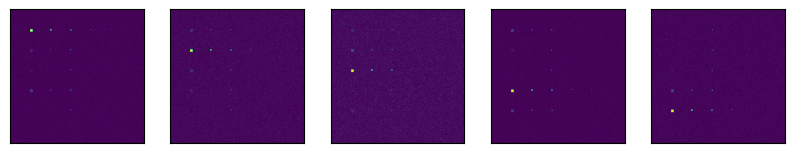

In [11]:
# Constrained Energy Minimizaiton (CEM)
# Function of CEM
def CEM(HSI, d):
  '''
  HSI: Hyperspectral Image
  d: Desired Target Signature
  '''

  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  # Calculate Auto-correlation matrix and its inverse
  R=r.T@r/N
  Rinv=np.linalg.inv(R)

  # Calculate CEM score map of each pixel
  scoreCEM = r@Rinv@d/(d.T@Rinv@d)
  scoreCEM = scoreCEM.reshape(x,y)

  return np.abs(scoreCEM)

# Compute CEM scores with 5 targets and TI2 hyperspectral image
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 10),subplot_kw={'xticks': [], 'yticks': []})
for idx, d in enumerate(matEmb[:,0:5].T):
  scoreCEM = CEM(ti2,d)
  axs[idx].imshow(scoreCEM)

plt.show()

This block computes ACE scores for 5 target minerals and displays them as images using matplotlib.

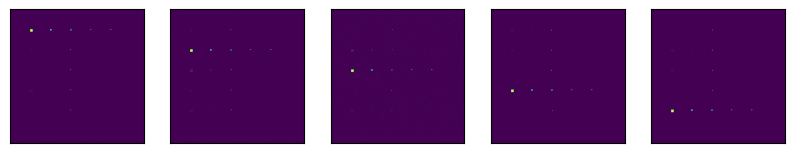

In [ ]:
# Adaptive Cosine Estimator (ACE)
def ACE(HSI,d):
  '''
  HSI: Hyperspectral Image
  d: Desired Target Signature
  '''

  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  u=np.mean(r,axis=0)

  r=r-np.tile(u,(N,1))
  d=d-u

  K=r.T@r/N
  invK=np.linalg.inv(K)

  upper=(r@invK@d)**2
  lower=(d.T@invK@d)*np.sum(r@invK*r,axis=1)
  scoreACE=upper/lower

  scoreACE=scoreACE.reshape(x,y)

  return scoreACE

# Compute ACE scores with 5 targets and TI2 hyperspectral image
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 10),subplot_kw={'xticks': [], 'yticks': []})
for idx, d in enumerate(matEmb[:,0:5].T):
  scoreACE = ACE(ti2,d)
  axs[idx].imshow(scoreACE)

plt.show()


This block computes MF scores for 5 target minerals and displays them as images using matplotlib.

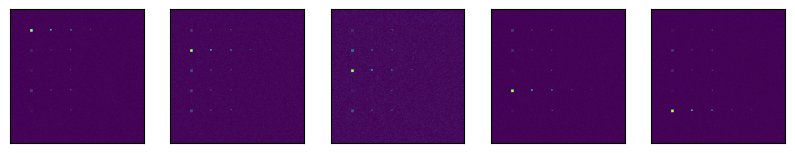

In [ ]:
# Match Filter (MF)
def MF(HSI,d):
  '''
  HSI: Hyperspectral Image
  d: Desired Target Signature
  '''

  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  u=np.mean(r,axis=0)

  r=r-np.tile(u,(N,1))
  d=d-u

  K=r.T@r/N
  invK=np.linalg.inv(K)

  scoreMF = r@invK@d/(d.T@invK@d)

  scoreMF=scoreMF.reshape(x,y)

  return np.abs(scoreMF)

# Compute ACE scores with 5 targets and TI2 hyperspectral image
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 10),subplot_kw={'xticks': [], 'yticks': []})
for idx, d in enumerate(matEmb[:,0:5].T):
  scoreMF = MF(ti2,d)
  axs[idx].imshow(scoreMF)

plt.show()


## 5.Target Detection with Desired Target Signature $\textbf{d}$ and Undesired Target Signature $\textbf{U}$

This block computes OSP scores for the first 5 target minerals and visualizes them.

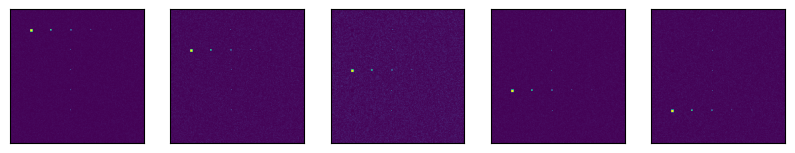

In [ ]:
# Orthogonal Subspace Projection (OSP)
def OSP(HSI,d,U):
  '''
  HSI: Hyperspectral Image
  d: Desired Target Signature
  U: Undesired Targets Signature
  '''

  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  P_U_per = np.eye(L)-U@np.linalg.inv(U.T@U)@U.T

  scoreOSP = d@P_U_per@r.T

  scoreOSP=scoreOSP.reshape(x,y)

  return np.abs(scoreOSP)

# Compute OSP scores with 5 targets and TI2 hyperspectral image
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 10),subplot_kw={'xticks': [], 'yticks': []})
for idx in range(5):
  d=matEmb[:,idx]
  U=matEmb
  U=np.delete(U,idx,axis=1)

  scoreOSP = OSP(ti2,d,U)
  axs[idx].imshow(scoreOSP)

plt.show()


This block computes TCIMF scores for the second and third target minerals as desired signature and visualizes them.

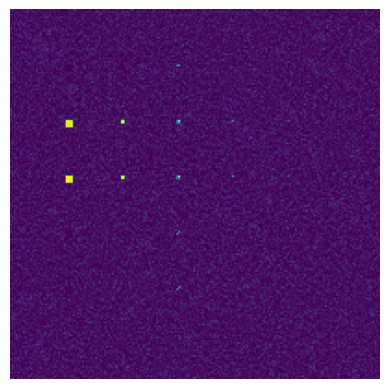

In [12]:
# Target Constrained Interference Minimizaiton Filter (TCIMF)
def TCIMF(HSI,D,U):
  '''
  HSI: Hyperspectral Image
  D: Desired Targets Signature
  U: Undesired Targets Signature
  '''

  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  p=D.shape[1]
  q=U.shape[1]

  # Calculate Auto-correlation matrix and its inverse
  R=r.T@r/N
  invR=np.linalg.inv(R)

  DU=np.concatenate((D,U),axis=1)
  I = np.concatenate((np.ones(p),np.zeros(q)))

  w=invR@DU@np.linalg.inv(DU.T@invR@DU)@I

  # Calculate TCIMF score map of each pixel
  scoreTCIMF = r@w
  scoreTCIMF = scoreTCIMF.reshape(x,y)

  return np.abs(scoreTCIMF)

# Compute TCIMF scores with 5 targets and TI2 hyperspectral image
D=matEmb[:,1:3]
U=matEmb
U=np.delete(U, np.s_[1:3],axis=1)

scoreTCIMF = TCIMF(ti2,D,U)

plt.imshow(scoreTCIMF)
plt.axis('off')
plt.show()

## 6.Unsupervised Target Detection

This block visualizes the detected target positions and their spectral signatures.

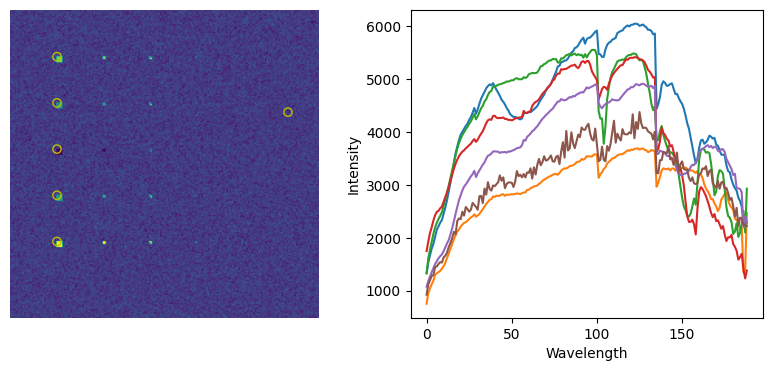

In [ ]:
# Automatic Target Generation Process (ATGP)
def ATGP(HSI,p):
  '''
  HSI: Hyperspectral Image
  p: Number of targets
  '''
  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  idxTgt = [np.argmax(np.sum(r*r,axis=1))]
  spTgt = r[idxTgt,:].squeeze()

  for idx in range(1,6):
    U = spTgt.T

    if U.ndim == 1:
      P_U_per = np.eye(L)-U@U.T/(U.T@U)
    else:
      P_U_per = np.eye(L)-U@np.linalg.pinv(U.T@U)@U.T

    scoreATGP = r@P_U_per*r
    idxNewTgt = np.argmax(np.sum(scoreATGP,axis=1))

    spTgt=np.vstack((spTgt,r[idxNewTgt,:].squeeze()))
    idxTgt.append(idxNewTgt)

  posTgt = np.unravel_index(idxTgt, (x,y), order='C')

  return posTgt, spTgt

# Using ATGP to unsupervisely find 6 targets
posTgt, spTgt = ATGP(ti2,6)

#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
#
axs[0].imshow(ti2[::,::,100])
axs[0].axis('off')
for pos_x, pos_y in zip(posTgt[1], posTgt[0]):
    axs[0].scatter(pos_x, pos_y, facecolors='none', edgecolors='y')
#
axs[1].plot(spTgt.T)
axs[1].set_xlabel('Wavelength')
axs[1].set_ylabel('Intensity')
plt.show()


## 7.Anomaly Detection

R-AD detects anomalies by computing the inverse of the auto-correlation matrix of the hyperspectral image and using it to calculate a score for each pixel. K-AD is similar to R-AD, but before calculating the score, it subtracts the mean of the hyperspectral image from each pixel, thus enhancing anomaly detection by centering the data around zero.

And this block displays the results of both the R-AD and K-AD anomaly detection methods, visualizing the anomalies detected in the hyperspectral image.

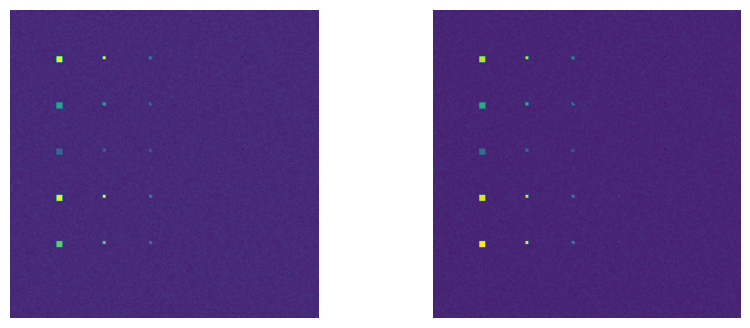

In [ ]:
# R-AD
def RAD(HSI):
  '''
  HSI: Hyperspectral Image
  '''
  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  # Calculate Auto-correlation matrix and its inverse
  R=r.T@r/N
  invR=np.linalg.inv(R)

  # Calculate RAD score map of each pixel
  scoreRAD = np.sum(r@invR*r,axis=1)
  scoreRAD = scoreRAD.reshape(x,y)

  return scoreRAD

# K-AD
def KAD(HSI):
  '''
  HSI: Hyperspectral Image
  '''
  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  u=np.mean(r,axis=0)

  r=r-np.tile(u,(N,1))

  K=r.T@r/N
  invK=np.linalg.inv(K)

  scoreKAD = np.sum(r@invK*r,axis=1)

  scoreKAD = scoreKAD.reshape(x,y)

  return scoreKAD

# Using R-AD and K-AD to Perform Anomaly Detection
scoreRAD = RAD(ti2)
scoreKAD = KAD(ti2)

# Display Results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].imshow(scoreRAD)
axs[0].axis('off')

axs[1].imshow(scoreKAD)
axs[1].axis('off')

plt.show()
